In [45]:
import os, time
import pandas as pd
import h5py

%matplotlib inline

from IPython.display import display, HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [46]:
# Create timestamp to show when this summary was run
print 'Summary run: ' + time.strftime("%a, %d %b %Y %H:%M")

Summary run: Tue, 01 Oct 2019 11:01


In [47]:
# Daysim data
trip = pd.read_csv(r'../../../outputs/daysim/_trip.tsv', sep='\t')
person = pd.read_csv(r'../../../outputs/daysim/_person.tsv', sep='\t')
hh = pd.read_csv(r'../../../outputs/daysim/_household.tsv', sep='\t')

In [48]:
pd.options.display.float_format = '{:0,.2f}'.format

In [49]:
# Weekdays in year
annual_factor = 300
minutes_to_hour =60

# Soundcast Metrics
----

### Average Daily Miles Driven per Person

In [50]:
drive_modes = [3, 4, 5]
drive_trips = trip[['mode', 'dorp', 'travtime', 'sov_ff_time', 'travdist']].loc[trip['mode'].isin(drive_modes)]
only_driver = drive_trips.loc[drive_trips['dorp']==1]
avg_vmt = only_driver['travdist'].sum()/ person['psexpfac'].sum()
print 'Average Daily VMT per person, not including externals or trucks: '+ str(avg_vmt)

Average Daily VMT per person, not including externals or trucks: 14.9655054481


### Hours of Congestion per Person per Year
For average Puget Sound resident:

In [51]:
drive_trips['delay'] = drive_trips['travtime']-(drive_trips['sov_ff_time']/100.0)

In [52]:
drive_trips['delay'] = drive_trips['travtime']-(drive_trips['sov_ff_time']/100.0)
drive_mode_delay =annual_factor*(drive_trips['delay'].sum()/person['psexpfac'].sum())/minutes_to_hour
print 'Annual hours of delay for residents, not including externals or trucks is ' + str(drive_mode_delay)

Annual hours of delay for residents, not including externals or trucks is 16.4793847256


### Annual Hours of Delay by Average Truck
Average annual delay (hours) per truck trip in and through the region:

In [53]:
# Total truck trips

In [54]:
# Load truck trips
df = pd.read_csv(r'../../../outputs/trucks/trucks_summary.csv',index_col=0)

# Truck delay
net_sum = pd.read_excel(r'../../../outputs/network/network_summary.xlsx', sheetname='Delay by UC')

# Annual delay hours
daily_delay = net_sum[['@mveh','@hveh']].sum().sum()


# total truck trips
trips = df['prod'].sum()

# average annual delay hours per truck
x = (daily_delay*annual_factor)/trips
print'{:0,.1f}'.format(x)

0.0


*Medium trucks only:*

In [56]:
x = (net_sum['@mveh'].sum()*annual_factor)/df.ix['mt','prod']
print '{:0,.1f}'.format(x)

0.0


*Heavy trucks only:*

In [57]:
x = (net_sum['@hveh'].sum()*annual_factor)/df.ix['ht','prod']
print '{:0,.1f}'.format(x)

0.0


### % Population Walking or Biking for Transportation

In [58]:
trip_person = pd.merge(trip,person,on=['hhno','pno'], how='left')
bike_walk_trips = trip_person[trip_person['mode'].isin([1,2])]

df = bike_walk_trips.groupby(['hhno','pno']).count()
df = df.reset_index()
df = df[['hhno','pno']]
df['bike_walk'] = True

df = pd.merge(person,df,on=['hhno','pno'], how='left')
df['bike_walk'] = df['bike_walk'].fillna(False)

pd.options.display.float_format = '{:,.1%}'.format
df = pd.DataFrame(df.groupby('bike_walk').sum()['psexpfac']/df['psexpfac'].sum())
print '{:,.1%}'.format(df.loc[True]['psexpfac'])

28.1%


## Household and Jobs within 1/4 mile transit

In [59]:
# Network data
df = pd.read_csv(r'../../../outputs/transit/transit_access.csv',index_col=0)

**Households**

In [60]:
x = df.ix['hh_p','quarter_mile_transit']
print '{:,.0f}'.format(x) + " households within 1/4 mile of transit"
x = df.ix['hh_p','quarter_mile_transit']/df.ix['hh_p','total']
print '{:,.1%}'.format(x) + " of total households"

767,431 households within 1/4 mile of transit
47.6% of total households


**Jobs**

In [61]:
x = df.ix['emptot_p','quarter_mile_transit']
print '{:,.0f}'.format(x) + " jobs within 1/4 mile of transit"
x = df.ix['hh_p','quarter_mile_transit']/df.ix['emptot_p','total']
print '{:,.1%}'.format(x) + " of total jobs"

1,511,597 jobs within 1/4 mile of transit
34.3% of total jobs


# Commute Times

In [62]:
pd.options.display.float_format = '{:0,.2f}'.format

In [63]:
workers = person.loc[person['pwautime']>0]
binned_times = pd.cut(workers['pwautime'], [0, 15, 30, 45, 60, 90, 200])
count_times = pd.value_counts(binned_times).sort_index()
print count_times

(0, 15]      493352
(15, 30]     714545
(30, 45]     395818
(45, 60]     187835
(60, 90]      97816
(90, 200]     19142
Name: pwautime, dtype: int64


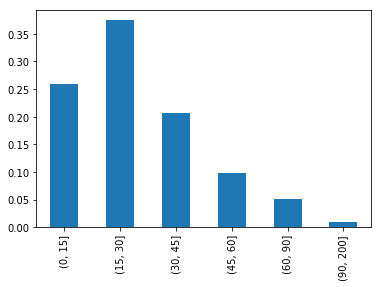

In [64]:
(count_times*1.0/len(workers)).plot.bar()